# Predict TripAdvisor Rating

## Задание
Необходимо предсказать рейтинг ресторана в TripAdvisor.

Одна из проблем компании TripAdvisor — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

## Описание признаков

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvisor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Загрузка необходимых библиотек

In [1419]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import warnings; warnings.simplefilter('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [1420]:
# Фиксируем RANDOM SEED

RANDOM_SEED = 42

In [1421]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы

!pip freeze > requirements.txt

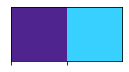

In [1422]:
# цветовая палитра для диаграмм seaborn
sns.palplot(sns.color_palette(['#50248f', '#38d1ff']))

## Функции, которые нам могут понадобиться

In [1423]:
# Вспомогательная функция для расчета и визуализации границ выбросов.

def show_IQR(pd_dataset, column_name, bins_n=10):
    """ 
       Вспомогательная функция для расчета и визуализации границ выбросов.
       на входе датасет, наименование столбца (признака) и количество столбиков гистограмы
       
       Выводит расчитанные параметры квантилей и гистограммы распределения и boxplot
    """
    data_column = pd_dataset[column_name]
    perc_25 = data_column.quantile(0.25, interpolation="midpoint")
    perc_75 = data_column.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(f'Q1: {perc_25}\nQ3: {perc_75}\nIQR: {IQR}',
          f'\nГраница выбросов: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]')
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data_column.values, bins=bins_n, color='#50248f')
    plt.title(column_name + ' Distribution\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(data_column.values, color='#38d1ff')
    plt.title(column_name + ' Distribution\n', fontsize=15)
    plt.xlabel(column_name)
    return 0

## Data

In [1424]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [1425]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [1426]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
6970,id_86,Paris,"['French', 'European', 'Vegetarian Friendly']",87.0,4.5,$$$$,633.0,[['If you love great food and terrific Burgun....,/Restaurant_Review-g187147-d4228364-Reviews-Le...,d4228364
16883,id_2764,Vienna,NaN,2766.0,4.0,NaN,4.0,"[['Reasonably price with friendly service'], [...",/Restaurant_Review-g190454-d8753377-Reviews-Vi...,d8753377
8977,id_1479,Lisbon,"['European', 'Portuguese']",1480.0,4.0,$,36.0,"[['Easy local food Resturant', 'Authentic Alfa...",/Restaurant_Review-g189158-d5959026-Reviews-Pa...,d5959026
12903,id_165,Zurich,"['Fast Food', 'Thai', 'Vegetarian Friendly']",166.0,4.5,$,162.0,"[['Lovely Thai Restaurant/Take-Away', 'Yummy a...",/Restaurant_Review-g188113-d1053095-Reviews-Ch...,d1053095
18983,id_315,Geneva,"['European', 'Vegetarian Friendly', 'Vegan Opt...",317.0,4.0,$$ - $$$,54.0,"[['Excellent buffet variety and quality!', 'La...",/Restaurant_Review-g188057-d7176369-Reviews-Ve...,d7176369


In [1427]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [1428]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [1429]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [1430]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


Для корректной обработки признаков объединяем train и test в один датасет (чтобы мы были уверены, что в тестовом и тренировочном наборах данных были бы одни и те же наборы признаков). 

In [1431]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [1432]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [1433]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
4273,id_4273,Stockholm,['Japanese'],2033.0,NaN,7.0,"[['Decent fish at great price', 'Daiichi Sundb...",/Restaurant_Review-g189852-d6891988-Reviews-Da...,d6891988,0,0.0
29820,id_6110,London,"['American', 'Diner', 'Fast Food', 'Halal']",6119.0,$$ - $$$,199.0,"[['Overpriced For What You Get.', 'Ok...some t...",/Restaurant_Review-g186338-d8051164-Reviews-Fa...,d8051164,1,3.5
11740,id_12331,London,"['Mexican', 'American', 'Indian', 'Caribbean',...",12341.0,$,NaN,"[['Really Enjoyed My Turkish Roti'], ['11/21/2...",/Restaurant_Review-g186338-d11829633-Reviews-W...,d11829633,1,4.0
31337,id_466,Krakow,"['European', 'Central European', 'Polish', 'Ve...",467.0,$$ - $$$,39.0,"[['Excellent Breakfast', 'Excellent hidden gem...",/Restaurant_Review-g274772-d2329334-Reviews-Re...,d2329334,1,4.5
12409,id_5035,London,"['Cafe', 'Fast Food', 'Vegetarian Friendly', '...",5044.0,$,156.0,[['Good value lunch with wide choice - suitab....,/Restaurant_Review-g186338-d3576897-Reviews-Pr...,d3576897,1,4.0


В объединенном наборе данных 10 первоначальных признаков и искусственный признак 'sample' для дальнейшего разделения датасета на тестовый и тренировочный). Три признака содержат числовые значениям, остальные - номинативы. Ниже проаналихируем детально каждый из признаков (в некоторых признаках присутствует большое количество пропусков).
 

## Cleaning and Prepping Data

In [1434]:
# посмотрим на кол-во пропусков, с которым предстоит работать

data.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

### Анализируем 'Restaurant_id'

Визуально видна зависимость между данным признаком и признаком ranking. Посмотрим на корреляцию.

In [1435]:
# Оставим тоьлко чистовые значения (уберем первые три символа 'id_')
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: float(x[3:]))

In [1436]:
data[['Restaurant_id', 'Ranking']].corr()

,Restaurant_id,Ranking
Restaurant_id,1.00000,0.82509
Ranking,0.82509,1.00000


> Корреляция есть, коэффициент корреаляции 0.82.

### Анализируем признак 'City'

In [1437]:
data['City'].describe()

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

In [1438]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

В поле 'City' нет пропусков. Всего 31 уникальный город. Это категориальный признак, его закодируем с помощию get_dummies и чуть позже (ниже) создадим дополнительные признаки на основе города.

### Анализируем 'Number of Reviews'

In [1439]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [1440]:
data['Number of Reviews'].isnull().sum()

3200

Признак содержит 3200 пропусков. Отсутствие данных значения может оказаться критичным для модели. Вынесем все пропуски в отдельный признак. А пропуски заполним нулем.

In [1441]:
data['number_of_rev_is_NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [1442]:
data['Number of Reviews'].fillna(0, inplace=True)

Q1: 7.0
Q3: 105.0
IQR: 98.0 
Граница выбросов: [-140.0, 252.0]


0

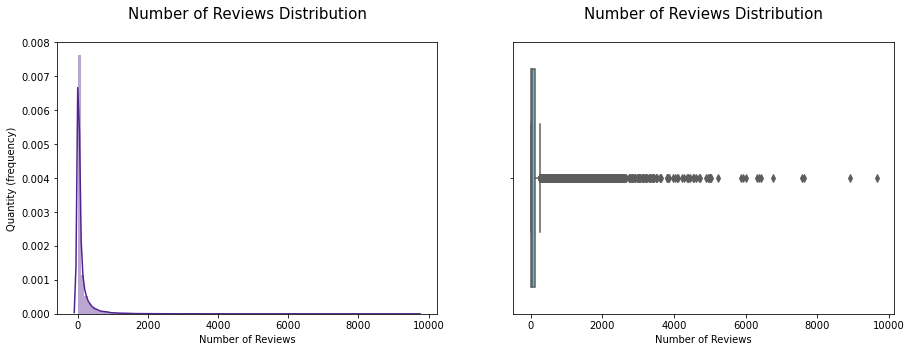

In [1443]:
# посмотрим, есть ли выбросы

show_IQR(data, 'Number of Reviews', 100)

Посмотрим, сколько значений у нас выбивается за верхнюю границу выбросов (больше, чем 252).

In [1444]:
sum(data['Number of Reviews'] > 252)

5946

За верхнюю границу выбросов выходит очень много значений, но на гистограмме распределения видно, что распределение смещено вправо и содержит очень длинный хвост, при чем, больше 2000 практически нет данных. Посмотрим, сколько значений в массиве содержит более 2000 отзывов:

In [1445]:
sum(data['Number of Reviews'] > 2000)

171

Заменим эти значения на 2000.

In [1446]:
data['Number of Reviews'] = data['Number of Reviews'].apply(lambda x: 2000 if x > 2000 else x)

In [1447]:
# проверим получивщиеся значения

data['Number of Reviews'].describe()

count    50000.000000
mean       112.523920
std        236.929092
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       2000.000000
Name: Number of Reviews, dtype: float64

### Анализируем 'Price Range'

In [1448]:
# количество пропусков данных:

sum(data['Price Range'].isnull())

17361

In [1449]:
# уникальные значения

data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Очень много пропусов данных, больше всего ресторанов в среднем ценовом сегменте.
Вынесем пропуски в отдельный признак, присвоим значениям порядковый номер, пропуски заменим на наиболее частое значение: 2.

In [1450]:
price = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3}
data['Price Range'] = data['Price Range'].map(price)
data['price_range_is_NAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price Range'] = data['Price Range'].fillna(2)

In [1451]:
data['Price Range'].describe()

count    50000.000000
mean         1.879320
std          0.421189
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

In [1452]:
# посмотрим, что получилось

data['Price Range'].value_counts()

2.0    40402
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

### Анализируем 'ID_TA'


In [1453]:
data['ID_TA'].value_counts()

d7342803     2
d697406      2
d9877640     2
d8753348     2
d3396817     2
            ..
d1892486     1
d8681015     1
d10082858    1
d12843306    1
d7304438     1
Name: ID_TA, Length: 49963, dtype: int64

Неожиданно, нас есть рестораны с одним и тем же идентификатором в системе (возможно, это сетевые рестораны или филиалы или дубли). Давайте посмотрим на них поподробнее. 

In [1454]:
# посмотрим, сколько у нас таких ресторанов

sum(data['ID_TA'].value_counts() > 1)

37

А если вернуться к колонке rest_id и посмотреть, есть ли там дважды встречающиеся значения.

In [1455]:
data['Restaurant_id'].value_counts()

633.0      19
227.0      19
436.0      19
871.0      19
71.0       18
           ..
11467.0     1
10963.0     1
12286.0     1
16148.0     1
9913.0      1
Name: Restaurant_id, Length: 13094, dtype: int64

In [1456]:
sum(data['Restaurant_id'].value_counts() >= 2)

9287

В ситуации с Restaurant_id можно предположить, что это сеть ресторанов, как Макдональдс или KFC. Следственно затем мы можем создать признак, который бы указывал, является ли ресторан частью сети или нет. В ситуации с id_ta может быть это некая компания, которая владеет несколькими разными ресторанами. Сказать сложно. Давайте отфильтруем эти значения и посмотрим на них повнимательнее.

In [1457]:
data['Restaurant_id'].nunique()

13094

In [1458]:
data_id_ta_notunique = data[data['ID_TA'].map(data['ID_TA'].value_counts()) > 1]

In [1459]:
data_id_ta_notunique['ID_TA'] = data_id_ta_notunique['ID_TA'].apply(lambda x: int(x[1:]))

In [1460]:
data_id_ta_notunique['ID_TA'].value_counts()

9802625     2
10316215    2
7827387     2
697406      2
3685055     2
8753348     2
3396817     2
793170      2
7342803     2
11999956    2
5618007     2
3647024     2
11674463    2
2360290     2
11921719    2
2669414     2
2010743     2
7809594     2
1235635     2
5617412     2
4748208     2
1315077     2
10047799    2
9877640     2
3161682     2
1028622     2
3748757     2
7337366     2
12488993    2
4600226     2
13002276    2
2477531     2
4914988     2
1568045     2
11698990    2
10440367    2
987900      2
Name: ID_TA, dtype: int64

In [1461]:
# посмотрим на пару таких ресторанов

data_id_ta_notunique.query('ID_TA == 987900')

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,number_of_rev_is_NAN,price_range_is_NAN
18019,2361.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0
32998,2312.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0


Мы видим, что все значения, кроме Restaurant_id совпадают. для окончательного вывода сравним URL.

In [1462]:
data_id_ta_notunique['URL_TA'][18019]

'/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html'

In [1463]:
data_id_ta_notunique['URL_TA'][32998]

'/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html'

Строки идентичны. Получается, что в наборе данныз дублируется 37 ресторанов. Т.к. по условиям задачи удалять строки из датасета нельзя, то ничего не меняем т дубликаты не удаляем. Возможно, в последствии, id_ta удалим за ненадобностью, но для порядка уберем символ d в начале и приведем к числовому значению. Возможно, ID_TA будет не лишним для модели, т.к. рестораны, которые зарегистрировались раньше получаю и меньший ID, возможно, такие рестораны уделяют больше внимания рейтингу.

In [1464]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

### Анализируем 'URL_TA'

In [1465]:
data.loc[data['URL_TA'][0]:5]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,number_of_rev_is_NAN,price_range_is_NAN
0,0.0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,0,0
1,1.0,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,0,0
2,2.0,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,0,0
3,3.0,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,0,0
4,4.0,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,0,0
5,5.0,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,1.0,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,8458643,0,0.0,0,0


In [1466]:
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

In [1467]:
data['URL_TA'][1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

Мы видим, что url ресторана состоит из двух закодированных величин. Первая, судя по совпадениям, означает город, вторая совпадает с id_ta. 
Пока не понятно, зачем нам может понадобиться код города (возможно, имеет смысл вместо города из столбца City использовать код, но пока в этом нет необходимости). 

Как вариант, можно было бы загрузить страницу ресторана с сайта TripAdvisor и взять оттуда напрямую значение рейтинга, но это не спортивно и мы так делать не будем. 

Еще как вариант, можно было бы с сайта TripAdvisor забрать все отзывы, стиль кухни и прочие данные, но это мы делать не будем, т.к. набор данных у нас явно не сегодняшний. а по состоянию на несколько лет тому назад и если мы будет подменять информацию из набора данных информацией с сайта, то будем решать уже другую задачу на ином наборе данных, поэтому никакую информацию с сайта забирать (в рамках этой задачи) не будем. 


Осталось проанализировать еще два тестовых признака: стиль кухни и отзывы. Так как это текстовые объекты, а нам для модели необходимы числовые, то данные признаки сами по себе мы обработать не можем, но можем на их основе создать новые числовые, чем и займемся ниже.

## Feature Engineering

### Анализируем 'Cuisine Style'

In [1468]:
type(data['Cuisine Style'][0])

str

Строковый тип..

In [1469]:
data['Cuisine Style'].isnull().sum()

11590

11590 пустых значений. Вынесем их в отдельный признак. Пустые значения в типе кухни заменим на значение "не определено" (Unknown). 

In [1470]:
data['cuisine_style_is_NAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [1471]:
# Пустые значения заполним категорией Unknown.

data['Cuisine Style'] = data['Cuisine Style'].fillna("['Unknown']")

In [1472]:
# преобразуем строку в список кухонь для удобства последующей работы

data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))

Добавим признак кол-ва кухонь в ресторане.

In [1473]:
data['number_of_cuisines'] = data['Cuisine Style'].apply(lambda x: len(x))

Проанализируем, какие кухни встречаются чаще, а какие являются самыми редкими.

In [1474]:
group_city_cuisine = data.groupby(['City'])['Cuisine Style'].sum().reset_index()

Посчитаем кол-во уникальных кухонь, используя счетчик. Посмотрим, какие кухни входят топ-10, как самые часто встречающиеся и как самые редко встречающиеся.

In [1475]:
c = collections.Counter()

for cuisine_style in group_city_cuisine['Cuisine Style']:
    for x in cuisine_style:
        c[x] += 1

print(c.most_common(10), "\n\n", c.most_common()[-10:])

[('Vegetarian Friendly', 14021), ('European', 12561), ('Unknown', 11590), ('Mediterranean', 7820), ('Italian', 7433), ('Vegan Options', 5684), ('Gluten Free Options', 5185), ('Bar', 4094), ('French', 3970), ('Asian', 3786)] 

 [('Caucasian', 4), ('Azerbaijani', 3), ('Welsh', 3), ('Yunnan', 2), ('Polynesian', 2), ('Fujian', 2), ('Latvian', 1), ('Burmese', 1), ('Salvadoran', 1), ('Xinjiang', 1)]


Само название кухни для человека и для модели скорее всего не очень важно, но важно распространенная ли это кухня (как Европейская) или она наоборот, редкая (такая как Уэльская)
Добавим признак, имеет ли ресторан кухню, входящую в топ-10 по популярности и по редкости.

In [1476]:
# сначала признак самых часто встречающихся кухонь

top_10_cuisine = []
top_10_cuisine = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() >= 3786].index.tolist()

In [1477]:
def most_common_cuisines(column):
    x = 0
    for i in top_10_cuisine:
        if i in column:
            x += 1
    return x

data['most_common_cuisine'] = data['Cuisine Style'].apply(most_common_cuisines)

In [1478]:
# теперь самые редкие

top_unique_cuisine = []
top_unique_cuisine = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() <= 4].index.tolist()

In [1479]:
def top_unique_cuisines(column):
    x = 0
    for i in top_unique_cuisine:
        if i in column:
            x += 1
    return x

data['top_unique_cuisine'] = data['Cuisine Style'].apply(top_unique_cuisines)

### Анализируем 'Reviews'

In [1480]:
data['Reviews'].isnull().sum()

2

In [1481]:
data['Reviews'].value_counts()

[[], []]                                                                                                         8112
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                                       2
[['Very cozy!', 'Service rate: 1'], ['01/17/2016', '11/18/2015']]                                                   2
[['Excellent'], ['09/03/2015']]                                                                                     2
[['Fantastic food, Excellent service', 'Surprising good Indian food in Spain'], ['01/07/2018', '11/08/2017']]       2
                                                                                                                 ... 
[['A new burger and beer spot at Sihlpost/HB...', 'Best Burgers in Town!'], ['12/27/2017', '11/26/2017']]           1
[['Nice pizza with food deals', 'Liars'], ['01/08/2017', '10/22/2016']]                                             1
[['Good beer', 'OK if you choose correctly'], ['12/13/20

Видно, что признак Reviews состоит из текстового отзыва и даты. Есть два пропуска явных и 8112 пропусков не явных, не имеющих внутри ничего кроме скобок. Отсутствие отзыва может быть важным для модели. Поэтому давайте вынесем все отзывы в отдельных признак.

In [1482]:
data['review_is_NAN'] = (data['Reviews'] == '[[], []]').astype('uint8')

In [1483]:
data['review_is_NAN'] = pd.isna(data['Reviews']).astype('uint8')

Выделим дату отзыва.

In [1484]:
data['date_of_review'] = data['Reviews'].apply(
    lambda x: [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))

Добавим признак кол-ва дней между отзывами.

In [1485]:
data['days_between_reviews'] = data.date_of_review.apply(lambda x: None if x == [] else pd.to_datetime(x).max() - pd.to_datetime(x).min())

In [1486]:
# посмторим на показатели

data.days_between_reviews.describe()

count                          41888
mean     123 days 05:05:55.462184874
std      212 days 14:08:22.315988208
min                  0 days 00:00:00
25%                  8 days 00:00:00
50%                 49 days 00:00:00
75%                148 days 00:00:00
max               3296 days 00:00:00
Name: days_between_reviews, dtype: object

Максимальный интервал между отзывами: 3296 дней. Давайте переведем значения в числа и посмотрим выбросы. 

In [1487]:
data['days_between_reviews'] = data['days_between_reviews'].apply(lambda x: x.days)

Q1: 8.0
Q3: 148.0
IQR: 140.0 
Граница выбросов: [-202.0, 358.0]


0

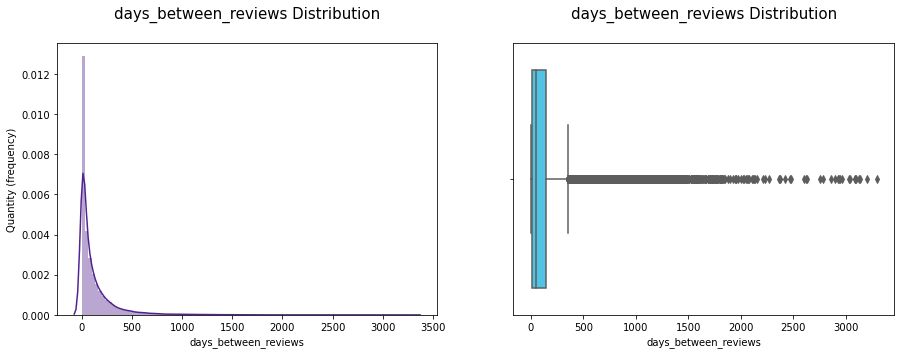

In [1488]:
# посмотрим распределение и возможные выбросы

show_IQR(data, 'days_between_reviews', 100)

In [1489]:
len(data.query('days_between_reviews > 365'))

3393

в 3393-х случаях между отзывами прошло больше года. 
У распределения очень длинный хвост вправо - падает практически до нуля при значениях больше 1000, наверное, имеет смысл больше трёх лет (3*365=1095) не учитывать отдельно, а добавить к трёхлетним значениям.

In [1490]:
len(data.query('days_between_reviews > 1095'))

385

In [1491]:
data.days_between_reviews = data.days_between_reviews.apply(lambda x: 1095 if x > 1095 else x)

In [1492]:
data.days_between_reviews.isnull().sum()

8112

Пропусков много, заполним пропуски медианой.

In [1493]:
data.days_between_reviews.describe()

count    41888.000000
mean       119.478180
std        185.985765
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       1095.000000
Name: days_between_reviews, dtype: float64

In [1494]:
data.days_between_reviews = data.days_between_reviews.fillna(data.days_between_reviews.median())

In [1495]:
# проверяем

data.days_between_reviews.isnull().sum()

0

Добавим еще один признак - кол-во дней с последнего отзыва до настоящего момента.

In [1496]:
data['days_tillnow'] = data.date_of_review.apply(
    lambda x: None if x == [] else datetime.now() - pd.to_datetime(x).max())

In [1497]:
data['days_tillnow'] = data['days_tillnow'].apply(lambda x: x.days)

In [1498]:
data.days_tillnow.isnull().sum()

8112

In [1499]:
data.days_tillnow.describe()

count    41888.000000
mean      1377.871276
std        382.403027
min       1087.000000
25%       1166.000000
50%       1240.500000
75%       1424.000000
max      18675.000000
Name: days_tillnow, dtype: float64

Заменим пропуски на среднее.

In [1500]:
data.days_tillnow = data.days_tillnow.fillna(data.days_tillnow.mean())

### Посмотрим распределение признаков

<AxesSubplot:>

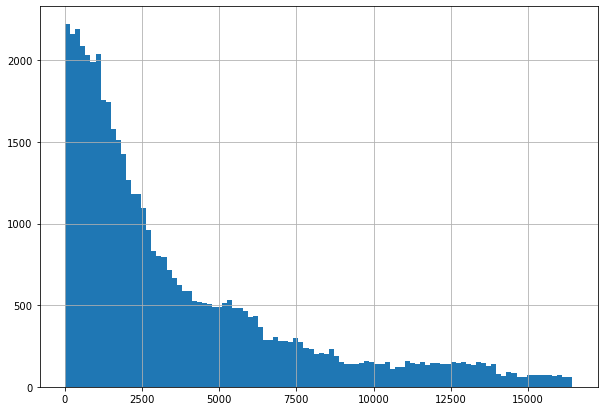

In [1501]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

<AxesSubplot:>

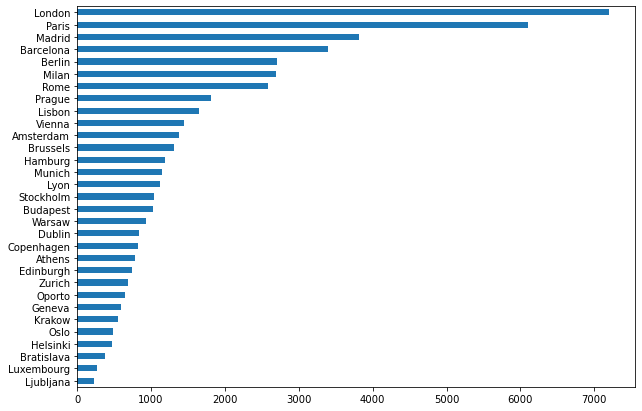

In [1502]:
data['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

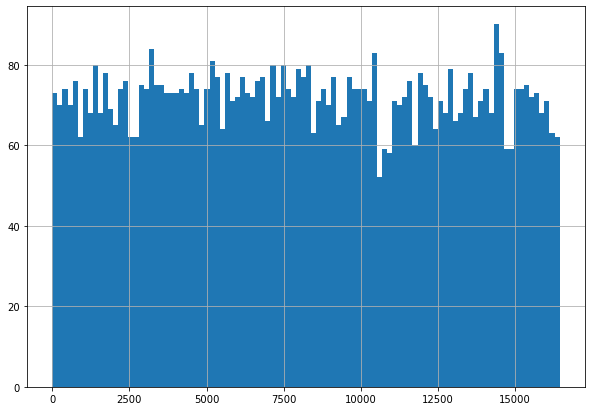

In [1503]:
data['Ranking'][data['City'] =='London'].hist(bins=100)

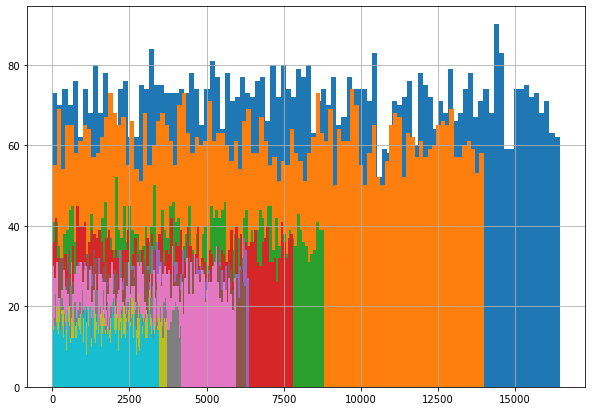

In [1504]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

<AxesSubplot:>

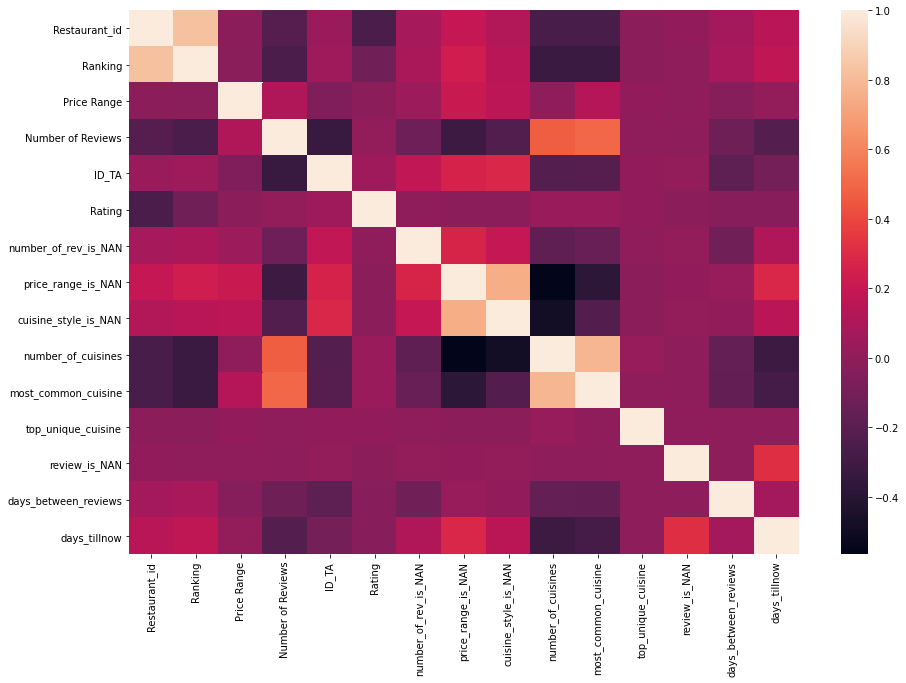

In [1505]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим несколько признаков, которые могут улучшить работу нашей модели.

In [1506]:
# Добавим признак - численность население (по данным из Википедии)

population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

data['Population'] = data['City'].map(population)

In [1507]:
# Используем сторонний справочник количества ресторанов в городах
res_count = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}
# Создадим новый признак 'Restaurants Count', отражающий общее количество ресторанов в городе, в котором расположен данный ресторан
data['Restaurants Count'] = data['City'].map(res_count)

In [1508]:
# Добавим признак - индекс покупательской способности согласно рейтингу Numbeo (2018)

purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

data['purchasing_power'] = data['City'].map(purchasing_power_index)

In [1509]:
# Добавим признак - является ли город столицей (1 - да, 0 - нет)

capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']
data['is_capital'] = data['City'].apply(lambda x: 1 if x in capital else 0)

In [1510]:
# Добавим признак кол-ва ресторанов в городе

number_of_rest_city = data.groupby('City')['Ranking'].count().to_dict()
data['rest_city_count'] = data['City'].map(number_of_rest_city)

In [1511]:
# Добавим признак относительного ранга ресторана по городу

data['city_ranking'] = data['Ranking'] / data.rest_city_count

In [1512]:
# Добавим числовой признак 'Population Per Restaurant' = 'Population' / 'Restaurants Count'
data['Population Per Restaurant'] = data['Population'] / data['Restaurants Count']

Смотрим дальше.. 

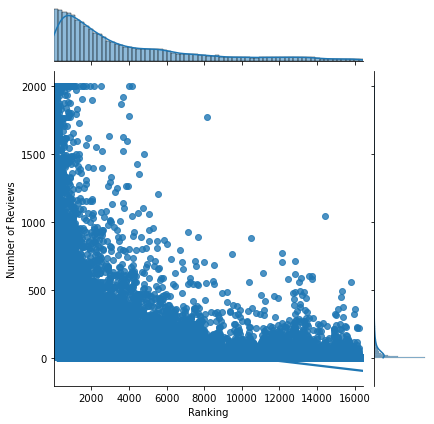

In [1513]:
sns.jointplot(x = 'Ranking', y = 'Number of Reviews', data = data, kind = 'reg')

<AxesSubplot:>

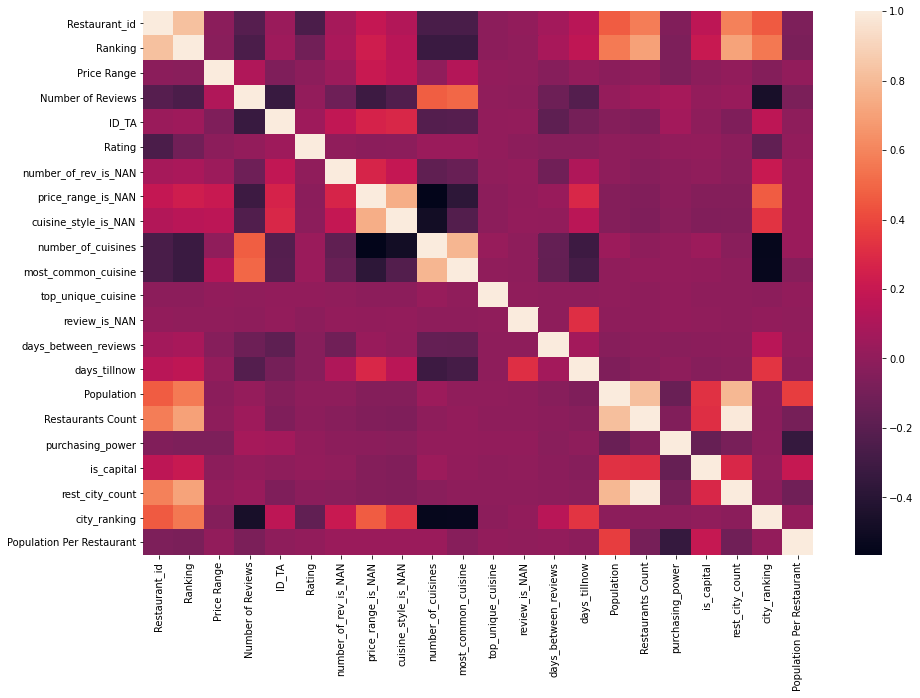

In [1514]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим следующие признаки:
- ранг ресторана на основании кол-ва отзывов
- соотношение кол-ва отзывов и населения города

In [1515]:
# ранг ресторана на основании кол-ва отзывов

data['ranking_rev_count'] = data['Ranking'] * data['Number of Reviews']

In [1516]:
# соотношение кол-ва отзывов и населения города

data['reviews_per_city_pop'] = data['Number of Reviews'] / data['Population']

In [1517]:
# Признак среднее кол-во отзывов в городе

mean_rev_per_city = data.groupby('City')['Number of Reviews'].mean()
mean_rev_per_city = mean_rev_per_city.apply(lambda x: round(x, 2))
data['mean_rev_per_city'] = data['City'].map(mean_rev_per_city)

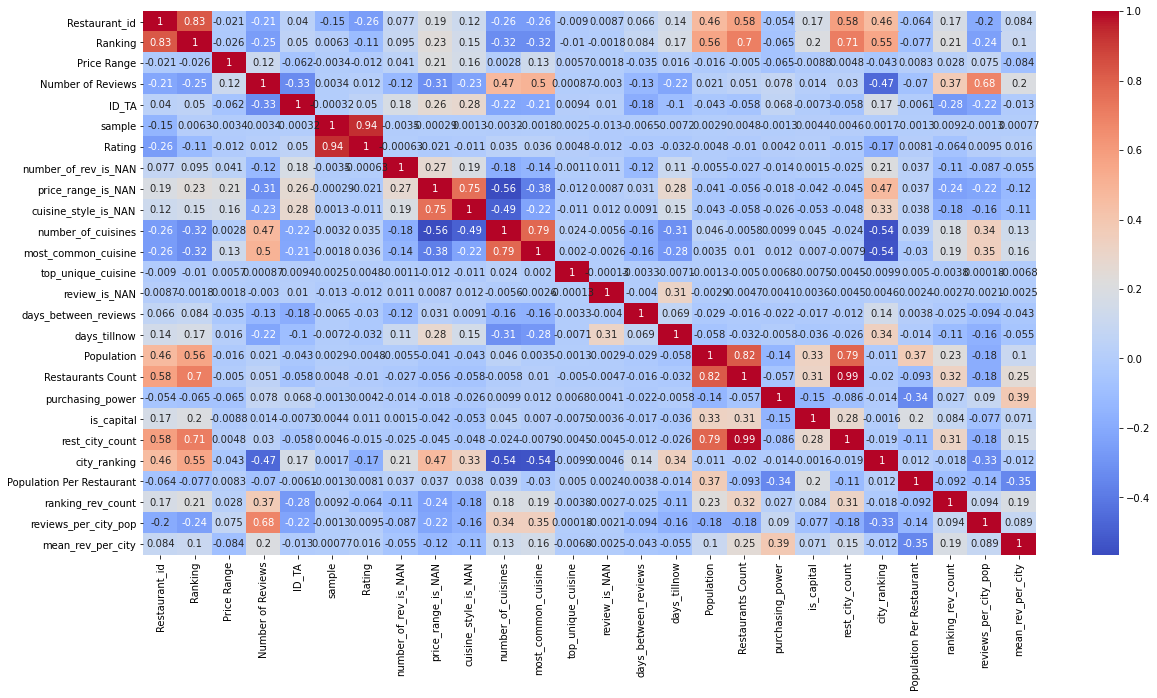

In [1518]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'coolwarm')

In [1519]:
# Добавим признак туристическая привлекательность.
# Место города в рейтинге топ-100 городов посещения в 2018 году (так как датасет устаревший)
# Источник - Euromonitor international

# Так как не все города входят в топ-100, то города делим на группы:
# 1 - место 1-25
# 2 - место 26-50
# 3 - место 51-75
# 4 - место 76-100
# 5 - место выше 100

tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

data['tourist_attract'] = data['City'].map(tourist_attract)

Так как у нас есть связь между городом и рангам большая и она сильно влияет на модель, создадим вспомогательный признак максимального ранга по городу.

In [1520]:
# Максимальный ранг

ranking_max_per_city = data.groupby('City')['Ranking'].max()
data['rating_max_per_city'] = data['City'].map(ranking_max_per_city)

### Отбор признаков

В ходе работы над проектом были также добавлены следующие признаки: длина отзыва, входит ле ресторан в сеть ресторанов, среднее кол-во туристов в городе, принадлежность к той или иной стране. Однако данные признаки ухудшили работу модели и от них было принято решение отказаться.

Также экспериментально было выяснено, что признаки rest_id, number_of_rev_is_NAN, review_is_NAN, is_capital также увеличивают MAE в итоге. Так что в при отборе признаков для модели, они также не учитывались.

## Закодируем признаки

In [1521]:
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

## Data Preprocessing

In [1522]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  float64
 1   Cuisine Style              50000 non-null  object 
 2   Ranking                    50000 non-null  float64
 3   Price Range                50000 non-null  float64
 4   Number of Reviews          50000 non-null  float64
 5   Reviews                    49998 non-null  object 
 6   URL_TA                     50000 non-null  object 
 7   ID_TA                      50000 non-null  int64  
 8   sample                     50000 non-null  int64  
 9   Rating                     50000 non-null  float64
 10  number_of_rev_is_NAN       50000 non-null  uint8  
 11  price_range_is_NAN         50000 non-null  uint8  
 12  cuisine_style_is_NAN       50000 non-null  uint8  
 13  number_of_cuisines         50000 non-null  int

In [1523]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 100)  # показывать больше колонок

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,number_of_rev_is_NAN,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,review_is_NAN,date_of_review,days_between_reviews,days_tillnow,Population,Restaurants Count,purchasing_power,is_capital,rest_city_count,city_ranking,Population Per Restaurant,ranking_rev_count,reviews_per_city_pop,mean_rev_per_city,tourist_attract,rating_max_per_city,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
21124,1411.0,"[Mediterranean, European, Spanish, Vegetarian ...",1413.0,2.0,335.0,"[['Tasty', 'Great tasting Tapas and lively atm...",/Restaurant_Review-g186338-d3943898-Reviews-Hi...,3943898,1,4.0,0,0,0,5,4,0,0,"[10/23/2017, 10/22/2017]",1.0,1213.000000,8909081,22366,24,1,7193,0.196441,398.331441,473355.0,3.760208e-05,124.00,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31991,2436.0,[Unknown],2441.0,2.0,83.0,"[['The best kept secret in London!', 'Great lo...",/Restaurant_Review-g186338-d8494851-Reviews-Bl...,8494851,1,4.5,0,1,1,1,1,0,0,"[12/07/2017, 12/07/2017]",0.0,1168.000000,8909081,22366,24,1,7193,0.339358,398.331441,202603.0,9.316337e-06,124.00,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33031,5441.0,[Unknown],5444.0,2.0,3.0,"[[], []]",/Restaurant_Review-g187514-d7992762-Reviews-Kr...,7992762,1,4.5,0,1,1,1,1,0,0,[],49.0,1377.871276,3223334,11562,23,1,3813,1.427747,278.786888,16332.0,9.307134e-07,90.08,2,8809.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
37220,3062.0,[Unknown],3064.0,2.0,17.0,"[[], []]",/Restaurant_Review-g187849-d12718522-Reviews-I...,12718522,1,4.0,0,1,1,1,1,0,0,[],49.0,1377.871276,1399860,7940,40,0,2694,1.137342,176.304786,52088.0,1.214407e-05,155.92,5,6275.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8104,8104.0,"[Steakhouse, European]",470.0,3.0,285.0,"[['Good but not great', 'Decent steak restaura...",/Restaurant_Review-g189158-d7366169-Reviews-K_...,7366169,0,0.0,0,0,0,2,1,0,0,"[12/02/2017, 09/17/2017]",76.0,1173.000000,505526,4985,48,1,1647,0.285367,101.409428,133950.0,5.637692e-04,116.86,3,3717.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1524]:
df_preproc = data.drop(
    ['Restaurant_id', 'Cuisine Style', 'Reviews', 'date_of_review',
    'number_of_rev_is_NAN', 'review_is_NAN', 'is_capital', 'URL_TA'], axis=1)

In [1525]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ranking                    50000 non-null  float64
 1   Price Range                50000 non-null  float64
 2   Number of Reviews          50000 non-null  float64
 3   ID_TA                      50000 non-null  int64  
 4   sample                     50000 non-null  int64  
 5   Rating                     50000 non-null  float64
 6   price_range_is_NAN         50000 non-null  uint8  
 7   cuisine_style_is_NAN       50000 non-null  uint8  
 8   number_of_cuisines         50000 non-null  int64  
 9   most_common_cuisine        50000 non-null  int64  
 10  top_unique_cuisine         50000 non-null  int64  
 11  days_between_reviews       50000 non-null  float64
 12  days_tillnow               50000 non-null  float64
 13  Population                 50000 non-null  int

In [1526]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data['Rating'].values            # Целевое значение
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [1527]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% а лучше 10% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)

In [1528]:
# проверяем

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 55), (40000, 55), (40000, 54), (32000, 54), (8000, 54))

## Model

In [1529]:
# Создаём модель 

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1530]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [1531]:
# Так как признак рейтинга имеет шаг 0.5, округляем предсказание.

y_pred = np.round(y_pred * 2) / 2

In [1532]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.163


<AxesSubplot:>

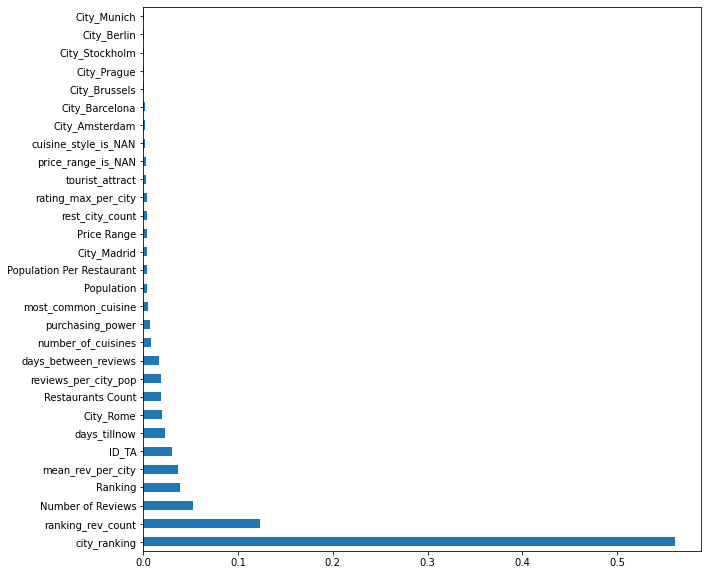

In [1533]:
# Cамые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

## Submission

In [1534]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,ID_TA,Rating,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,days_between_reviews,days_tillnow,Population,Restaurants Count,purchasing_power,rest_city_count,city_ranking,Population Per Restaurant,ranking_rev_count,reviews_per_city_pop,mean_rev_per_city,tourist_attract,rating_max_per_city,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
3264,2000.0,2.0,23.0,12958340,0.0,0,0,2,0,0,49.0,1377.871276,2860009,12086,37,2589,0.772499,236.638176,46000.0,0.000008,267.70,1,5948.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3231,1677.0,2.0,4.0,4510033,0.0,1,1,1,1,0,0.0,1912.000000,794128,2637,10,819,2.047619,301.148275,6708.0,0.000005,88.21,3,1964.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2201,220.0,2.0,134.0,11961032,0.0,0,0,7,5,0,7.0,1140.000000,2860009,12086,37,2589,0.084975,236.638176,29480.0,0.000047,267.70,1,5948.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6388,12535.0,2.0,0.0,12714120,0.0,1,0,1,0,0,49.0,1377.871276,8909081,22366,24,7193,1.742666,398.331441,0.0,0.000000,124.00,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8974,1630.0,2.0,378.0,8448872,0.0,0,0,4,4,0,46.0,1180.000000,2148271,17593,22,6108,0.266863,122.109419,616140.0,0.000176,109.76,1,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2576,543.0,2.0,108.0,1186902,0.0,0,0,4,4,0,183.0,1125.000000,1208542,3703,15,1314,0.413242,326.368350,58644.0,0.000089,83.20,3,3006.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9274,2256.0,2.0,8.0,8145208,0.0,1,1,1,1,0,297.0,1162.000000,2600000,4387,21,1443,1.563410,592.660132,18048.0,0.000003,70.40,2,3444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1887,407.0,2.0,1013.0,2270635,0.0,1,0,3,3,0,121.0,1181.000000,2860009,12086,37,2589,0.157204,236.638176,412291.0,0.000354,267.70,1,5948.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
931,4164.0,2.0,25.0,1878972,0.0,1,1,1,1,0,36.0,1652.000000,3769495,8110,8,2705,1.539372,464.795931,104100.0,0.000007,57.30,2,6372.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9686,1631.0,2.0,19.0,3647716,0.0,0,0,2,2,0,228.0,1445.000000,554554,2706,27,836,1.950957,204.934959,30989.0,0.000034,142.83,5,1960.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1535]:
test_data = test_data.drop(['Rating'], axis=1)

In [1536]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [1537]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [1538]:
predict_submission = np.round(predict_submission * 2) / 2

In [1539]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [1540]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
